## Generate files for detector model from simulation files

Want to have combined Aeff and Eres for all channels and flavours to keep things simple. Also will add in HESE cut manually after for consistency with tracks and easy editing. 

In [1]:
import numpy as np
from matplotlib import pyplot as plt
import pandas as pd
import os

#### Aeff 

In [2]:
e_bins = np.linspace(np.log10(3e4), 8.5, 51)
cosz_bins = np.linspace(-1, 1, 11)

path = "simulation_files"
filenames = os.listdir(path)

In [3]:
# Total Aeff
aeff_list = []
for name in filenames:
    
    # Ignore track-like signatures 
    if not "numu_CC" in name and not "numubar_CC" in name:
    
        # Get histogram
        df = pd.read_hdf(os.path.join(path, name))
        w = df['generation_weight'] * 1e-4 / (2.*np.pi)
        h, xbins, ybins = np.histogram2d(np.log10(df["prim_energy"]), 
                                         df["prim_coszenith"], 
                                        bins=[e_bins, cosz_bins], weights=w)
        # Normalise to bin area
        aeff = np.zeros_like(h)
        for i, l10E in enumerate(xbins[:-1]):
            for j, cosz in enumerate(ybins[:-1]):
                bin_area = ((10**xbins[i+1] - 10**l10E) * (ybins[j+1] - cosz))
                aeff[i][j] = h[i][j] / bin_area
                
        aeff_list.append(aeff)
        
aeff_tot = np.sum(aeff_list, axis=0) / 6.0 # flavours and nu/nubar

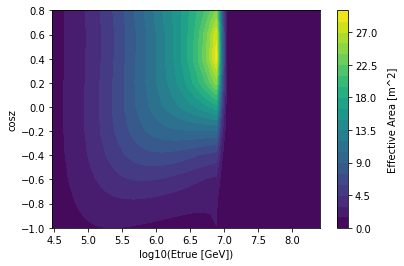

In [4]:
fig, ax = plt.subplots()
cf = ax.contourf(e_bins[:-1], cosz_bins[:-1], aeff_tot.T, levels=20)
cbar = fig.colorbar(cf)
ax.set_xlabel("log10(Etrue [GeV])")
ax.set_ylabel("cosz")
cbar.set_label("Effective Area [m^2]", labelpad=10)

#### Eres

In [5]:
tE_bins = np.linspace(np.log10(3e4), 7, 51)
rE_bins = np.linspace(3, 7, 51)

In [6]:
# Total Eres 
eres_list = []
for name in filenames:
    
    # Ignore track-like signatures 
    if not "numu_CC" in name and not "numubar_CC" in name:
        
        # Get histogram
        df = pd.read_hdf(os.path.join(path, name))
        h, xbins, ybins = np.histogram2d(np.log10(df['prim_energy']),
                                         np.log10(df['rec_energy']), 
                                         bins=[tE_bins, rE_bins])
        eres_list.append(h)
        
eres_tot = np.sum(eres_list, axis=0) / 6.0 # flavours and nu/nubar

# Norm along Ereco
bin_width = ybins[1] - ybins[0]
for i, pdf in enumerate(eres_tot):
    eres_tot[i] = pdf / (pdf.sum() * bin_width)

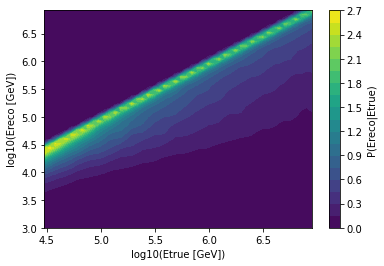

In [7]:
fig, ax = plt.subplots()
cf = ax.contourf(xbins[:-1], ybins[:-1], eres_tot.T, levels=20)
ax.set_xlabel("log10(Etrue [GeV])")
ax.set_ylabel("log10(Ereco [GeV])")
cbar = fig.colorbar(cf)
cbar.set_label("P(Ereco|Etrue)")

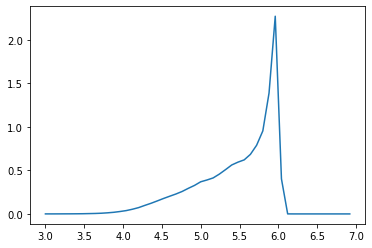

In [8]:
fig, ax = plt.subplots()
ax.plot(rE_bins[:-1], eres_tot[30])

#### Save to file

In [9]:
import h5py
with h5py.File("cascade_detector_model_test.h5", "w") as f:
    
    aeff_folder = f.create_group("aeff")
    aeff_folder.create_dataset("tE_bin_edges", data=10**e_bins)
    aeff_folder.create_dataset("cosz_bin_edges", data=cosz_bins)
    aeff_folder.create_dataset("aeff", data=aeff_tot)
    
    eres_folder = f.create_group("eres")
    eres_folder.create_dataset("tE_bin_edges", data=10**tE_bins)
    eres_folder.create_dataset("rE_bin_edges", data=10**rE_bins)
    eres_folder.create_dataset("eres", data=eres_tot)